In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [52]:
objpoints = []
imgpoints = []

images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

    else:
        im_num = int(fname.split('.')[0][-1])
        if im_num == 5:
            ret, corners = cv2.findChessboardCorners(gray, (7,5), None)
            objp = np.zeros((5*7,3), np.float32)
            objp[:,:2] = np.mgrid[0:5,0:7].T.reshape(-1,2)
        elif im_num == 4:
            ret, corners = cv2.findChessboardCorners(gray, (6,5), None)
            objp = np.zeros((5*6,3), np.float32)
            objp[:,:2] = np.mgrid[0:6,0:5].T.reshape(-1,2)
        elif im_num == 1:
            ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
            objp = np.zeros((5*9,3), np.float32)
            objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)
        assert ret
        objpoints.append(objp)
        imgpoints.append(corners)

In [53]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.T.shape, None, None)

In [54]:
straight = plt.imread('test_images/straight_lines1.jpg')
straight_gray = cv2.cvtColor(straight, cv2.COLOR_RGB2GRAY)
trap_pts = np.array([[197,720], [580, 460], [702, 460], [1115, 720]], np.int32)
trap = np.copy(straight_gray)
trap = cv2.polylines(trap, [trap_pts], True, (0, 255, 0), thickness = 2)
src_pts = np.float32(trap_pts)
dest_pts = np.array([[350, 720], [350, 0], [970, 0], [970, 720]], np.float32)
M = cv2.getPerspectiveTransform(src_pts, dest_pts)
Minv = cv2.getPerspectiveTransform(dest_pts, src_pts)

In [55]:
def warp(img, M):
    warped = cv2.warpPerspective(img, M, (1280, 720), flags = cv2.INTER_LINEAR)
    return warped

In [56]:
def color_thresh(img, thresh = (0, 255)):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue = hsv[:,:,0]
    sat = hsv[:,:,1]
    blue = img[:,:,2]
    binary_output = np.zeros_like(hue)

    binary_output[(((hue > 20) & (hue < 30)) & ((sat > 130) & (sat < 230))) | ((blue > 190)&(blue < 255))] = 1
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(binary_output,kernel,iterations = 1)
    
    return binary_output

def mag_thresh(img, ksize = 3, thresh = (0, 255)):
    
    assert ksize % 2 == 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat = hls[:,:,2]
    sobelx = cv2.Sobel(sat, cv2.CV_64F, 1, 0, ksize = ksize)
    sobely = cv2.Sobel(sat, cv2.CV_64F, 0, 1, ksize = ksize)
#   scaling magnitude of y because it introduces noise
    abs_sobelxy = np.sqrt(sobelx**2 + 0.01 * sobely**2)
    scaled = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    
    return binary_output

In [57]:
def reinforce(img, kernel = (5, 5)):
    kernel = np.ones(kernel, np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening

In [58]:
def util(result, leftx, lefty, rightx, righty, left_fitx, right_fitx):
    
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    rad = (left_curverad + right_curverad)/2
    middle = (left_fitx[-1] + right_fitx[-1])//2
    position = img.shape[1]//2
    l_or_r = (position - middle)*xm_per_pix
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of curvature  = %.2f m'%(rad),(400,200), font, 1,(255,255,255),3,cv2.LINE_AA)
#     cv2.putText(result,'Right radius of curvature = %.2f m'%(right_curverad),(150,90), font, 1,(255,0,0),3,cv2.LINE_AA)
#     cv2.putText(result,'Left radius of curvature = %.2f m'%(left_curverad),(150,130), font, 1,(255,0,0),3,cv2.LINE_AA)

    cv2.putText(result,'Position = %.2f m %s of center'%(abs(l_or_r), 'left' if l_or_r < 0 else 'right'),(400,240),
                        font, 1,(255,255,255),3,cv2.LINE_AA)
    return result, rad

In [59]:
found = 0

In [60]:
def pipeline(img, mtx, dist, M, Minv, found):
    
    _input = cv2.undistort(img, mtx, dist, None, mtx)
    _input = cv2.GaussianBlur(_input, (5,5), 0)
    _input = warp(img, M)
    
#   Collecting all the filter images
    mag_binary = mag_thresh(_input, ksize = 9, thresh = (30, 100))
    color_binary = color_thresh(_input, thresh = (10, 60))
    
#   Applying all the filters
    combined = np.zeros_like(mag_binary)
    combined[(mag_binary == 1) | (color_binary == 1)] = 1
    
    binary_warped = reinforce(combined)
    
    if not found:
        histogram = np.sum(binary_warped, axis = 0)
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        nwindows = 9
        window_height = np.int(binary_warped.shape[0]/nwindows)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
        margin = 100
        minpix = 50
        left_lane_inds = []
        right_lane_inds = []
        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, 719, num=720)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        final, rad = util(result, leftx, lefty, rightx, righty, left_fitx, right_fitx)
        
    else:
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        final = util(result)
        print("in this")
        
    return final

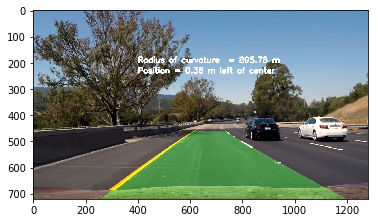

In [61]:
test = plt.imread('test_images/test6.jpg')
check = pipeline(test, mtx, dist, M, Minv, found)
plt.imshow(check)

In [62]:
def process_image(image):
    result = pipeline(image, mtx, dist, M, Minv, found)    
    return result

In [63]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [64]:
white_output = 'submission.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video submission.mp4
[MoviePy] Writing video submission.mp4


100%|█████████▉| 1260/1261 [04:49<00:00,  4.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: submission.mp4 

CPU times: user 9min 45s, sys: 56.8 s, total: 10min 42s
Wall time: 4min 51s
